In [161]:
import gc
import time
import copy
import torch 
import torchvision

import numpy as np
import torch.nn as nn
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, default_collate
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
from sklearn.metrics import precision_score, recall_score
from torchmetrics.functional.classification import (
    multilabel_recall,
    multiclass_precision,
    multiclass_confusion_matrix
)
from torch.nn.functional import one_hot

from dropblock import DropBlock2D

In [210]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [162]:
%env PYTORCH_ENABLE_MPS_FALLBACK 1


env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [166]:
device = torch.device("mps") or torch.device("cpu")
device

device(type='mps')

In [167]:
dataset = ImageFolder(
    'shoe-data/', 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([102, 136])
    ])
)

In [168]:
labels_map = {
    0: 'Boot',
    1: 'Sandal',
    2: 'Shoe'
}

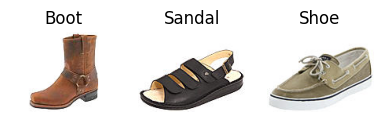

In [169]:

seen_labels = [] 

cur_index = 1

figure = plt.figure(figsize=(8, 4))

for idx in range(len(dataset)): 
    if len(seen_labels) == 10: 
        break 
    img, label = dataset[idx]
    if label in seen_labels: 
        continue 
    seen_labels.append(label)
    figure.add_subplot(2, 5, cur_index)
    cur_index = cur_index + 1
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")

plt.show()

In [170]:
train_data, test_data = random_split(dataset, lengths=[0.7, 0.3])
train_data, val_data = random_split(train_data, lengths=[0.7, 0.3])


In [171]:
BATCH_SIZE = 100
dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
#     collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))
)

testloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
#     collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))
)

valloader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
#     collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))
)

In [172]:
class MLPModel(nn.Module):
    def __init__(self): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(41616, 10),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(10, 3)
        )
        
    def forward(self, x): 
        return self.layers(x)

In [173]:
m = MLPModel()
print(f"The MLP model has {count_parameters(m)} parameteres")

The MLP model has 416313 parameteres


In [175]:
def test_model(model, loss_fn, testloader, writer=None): 
    
    print(f"The model has {count_parameters(cnn_model)} parameteres")
    
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    loss = 0
    total_recall = 0 
    total_precision = 0
    total_conf_mat = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
    
    print("test has been started")
    
    with torch.no_grad():
        
        for images, labels in testloader:
            images = images.to(device)
                
            test_pred = model(images)
        

            _, cat = torch.max(test_pred, 1)
            
            recall = multilabel_recall(test_pred.cpu(), one_hot(labels.cpu()), num_labels=3)
            precision = multiclass_precision(test_pred.cpu(), labels.cpu(), num_classes=3)
            conf_mat = multiclass_confusion_matrix(test_pred.cpu(), labels.cpu(), num_classes=3)
            labels = labels.to(device)
            
            total_recall += recall * labels.size(0)
            total_precision += precision * labels.size(0)
            total_conf_mat += conf_mat

            loss += loss_fn(test_pred, labels)
            
            correct += torch.sum(cat == labels.data)
            total += labels.size(0)

    print("precision is: ", total_precision / total)
    print("recall is: ", total_recall / total)
    print("conf mat is: ", total_conf_mat)
            
    return loss, correct / total 

def train_model(model, dataloaders, loss_fn, optimizer, epochs, writer=None): 
    model.to(device)
    
    starting_time = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    val_acc_hist = []
    
    for i in (t := trange(epochs)): 
        for phase in ['train', 'val']: 
            if phase == 'train': 
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for images, labels in dataloaders[phase]:
                images = images.to(device)
                labels = labels.to(device)
                
#                 print(images.shape)
#                 print(labels.shape)
                
#                 images = images.reshape(1, -1)
#                 print(images.shape)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): 
                    outs = model(images)
#                     print(outs.shape)
                    loss = loss_fn(outs, labels)
                
#                 break
                _, preds = torch.max(outs, 1)
                
#                 print(labels.data.shape)
#                 print(preds.shape)
#                 break
                
                if phase == 'train': 

                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
#             print("geeez", running_corrects, len(dataloaders[phase].dataset))
            
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc 
                best_model = copy.deepcopy(model.state_dict())
                
            if phase == 'val': 
                val_acc_hist.append(epoch_acc)
                t.set_description("loss %.2f accuracy %.2f" % (epoch_loss, epoch_acc))

                
            if writer is not None: 
                writer.add_scalar(f'Loss/{phase}', epoch_loss, i)
                writer.add_scalar(f'Acc/{phase}', epoch_acc, i)

            torch.cuda.empty_cache()
            gc.collect()

    model.load_state_dict(best_model)
     
    time_elapsed = time.time() - starting_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
        
    return model




In [177]:
writer = SummaryWriter("runs/mlp-model/")
model = MLPModel()
sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

model = train_model(
    model, 
    {'train': dataloader, 'val': valloader},
    loss_fn, 
    sgd, 
    100, 
    writer)

images, labels = next(iter(dataloader))
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images.to(device))
writer.close()

loss 0.78 accuracy 0.72: 100%|████████████████| 100/100 [07:08<00:00,  4.28s/it]


Training complete in 7m 8s
Best val Acc: 0.734286


In [178]:
test_model(
    model, 
    loss_fn, 
    testloader
)

test has been started
precision is:  tensor(0.7522)
recall is:  tensor(0.9395)
conf mat is:  tensor([[1432,    2,   66],
        [  76, 1092,  326],
        [ 142,  480,  884]])


(tensor(34.5401, device='mps:0'), tensor(0.7573, device='mps:0'))

In [179]:
print(f"The MLP model has {count_parameters(model)} parameteres")

The MLP model has 416313 parameteres


In [208]:
class CNNModelD(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 20, 5),
            nn.Dropout(p=0.3),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 16, 3),
            nn.Dropout(p=0.3),
            nn.ReLU(), 
            nn.MaxPool2d(3, 3),
            nn.Conv2d(16, 10, 5), 
            nn.Dropout(p=0.3), 
            nn.ReLU(), 
            nn.Flatten(),
            nn.Linear(1870, 50),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(50), 
            nn.ReLU(),
            nn.Linear(50, 3), 
        )
        
    def forward(self, x): 
        return self.layers(x)

In [204]:
class CNNModelBD(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 20, 5),
            DropBlock2D(block_size=5, drop_prob=0.3),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 16, 3),
            DropBlock2D(block_size=3, drop_prob=0.3), 
            nn.ReLU(), 
            nn.MaxPool2d(3, 3),
            nn.Conv2d(16, 10, 5), 
            DropBlock2D(block_size=5, drop_prob=0.3),
            nn.ReLU(), 
            nn.Flatten(),
            nn.Linear(1870, 50),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(50), 
            nn.ReLU(),
            nn.Linear(50, 3), 
        )
        
    def forward(self, x): 
        return self.layers(x)

In [222]:
class CNNModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 20, (1, 5)),
#             DropBlock2D(block_size=5, drop_prob=0.3),
            nn.ReLU(),
            nn.Conv2d(20, 20, (5, 1)),
            DropBlock2D(block_size=5, drop_prob=0.3),
            nn.ReLU(),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 20, (1, 3)),
#             DropBlock2D(block_size=3, drop_prob=0.3), 
            nn.ReLU(),
            nn.Conv2d(20, 16, (3, 1)),
            DropBlock2D(block_size=3, drop_prob=0.3), 
            nn.ReLU(), 
            nn.MaxPool2d(3, 3),
            nn.Conv2d(16, 16, (1, 5)), 
#             DropBlock2D(block_size=5, drop_prob=0.3),
            nn.ReLU(),
            nn.Conv2d(16, 10, (5, 1)), 
            DropBlock2D(block_size=5, drop_prob=0.3),
            nn.ReLU(), 
            nn.Flatten(),
            nn.Linear(1870, 50),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(50), 
            nn.ReLU(),
            nn.Linear(50, 3), 
        )
        
    def forward(self, x): 
        return self.layers(x)

As we can see from the results, cnn models are much better and faster than mlp models. This is because they try to find features using local neighbours. 

In [213]:
writer = SummaryWriter("runs/cnn-model-dropout/")
cnn_model = CNNModelD()
sgd = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
train_model(
    cnn_model, 
    {'train': dataloader, 'val': valloader},
    loss_fn, 
    sgd, 
    50,
    writer
)
writer.close()
test_model(cnn_model, loss_fn, testloader)

loss 0.26 accuracy 0.92: 100%|██████████████████| 50/50 [06:51<00:00,  8.22s/it]


Training complete in 6m 51s
Best val Acc: 0.955556
test has been started
precision is:  tensor(0.9625)
recall is:  tensor(0.9798)
conf mat is:  tensor([[1495,    3,    2],
        [  46, 1373,   75],
        [  39,    9, 1458]])


(tensor(8.8929, device='mps:0'), tensor(0.9613, device='mps:0'))

In [214]:
writer = SummaryWriter("runs/cnn-model-block-dropout/")
cnn_model = CNNModelBD()
sgd = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
train_model(
    cnn_model, 
    {'train': dataloader, 'val': valloader},
    loss_fn, 
    sgd, 
    50,
    writer
)
writer.close()
test_model(cnn_model, loss_fn, testloader)

loss 0.15 accuracy 0.95: 100%|██████████████████| 50/50 [08:48<00:00, 10.57s/it]


Training complete in 8m 49s
Best val Acc: 0.961587
test has been started
precision is:  tensor(0.9643)
recall is:  tensor(0.9843)
conf mat is:  tensor([[1472,   10,   18],
        [  30, 1388,   76],
        [  19,   11, 1476]])


(tensor(6.1040, device='mps:0'), tensor(0.9636, device='mps:0'))

Using normal dropout instead of block-dropout may cause recognizing features incorrectly. As the main paper of block dropout says "This lack of success of dropout for convolutional layers is perhaps due to the fact that activation units in convolutional layers are spatially correlated so information can still flow through convolutional networks despite dropout". This means that if we use normal dropout, in a single convolutional operation we may drop some units but use the others and learn a feature which does not all units related to that feature. As you can see, the accuracy of validation data has been increased using block dropout because it's a better normalization for cnn networks

In [223]:
writer = SummaryWriter("runs/cnn-model/")
cnn_model = CNNModel()
sgd = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
train_model(
    cnn_model, 
    {'train': dataloader, 'val': valloader},
    loss_fn, 
    sgd, 
    60,
    writer
)
writer.close()
test_model(cnn_model, loss_fn, testloader)

loss 0.30 accuracy 0.90: 100%|██████████████████| 60/60 [13:56<00:00, 13.94s/it]


Training complete in 13m 56s
Best val Acc: 0.941905
test has been started
precision is:  tensor(0.9429)
recall is:  tensor(0.9698)
conf mat is:  tensor([[1477,   13,   10],
        [  58, 1366,   70],
        [  77,   35, 1394]])


(tensor(9.4021, device='mps:0'), tensor(0.9416, device='mps:0'))

In [224]:
print(f"The CNN simple dropout model has {count_parameters(CNNModelD())} parameteres")
print(f"The CNN block dropout model has {count_parameters(CNNModelBD())} parameteres")
print(f"The CNN kernel factorization model has {count_parameters(CNNModel())} parameteres")


The CNN simple dropout model has 102229 parameteres
The CNN block dropout model has 102229 parameteres
The CNN kernel factorization model has 100445 parameteres


Kernel factorization reduces the number of parameteres, as we can see, so it speed up the training process. Also with kernel factorization we have more normality because we apply two activation function (e.g ReLU) to our data and it helps to understand more complicated features. 